In [1]:
#Dynamic circuit of long range CNOT gate for odd number of qubits

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.classical import expr

def get_CNOT_circuit_dynamic_1(num_qubit):
    """
    (1) 1D chain of nearest neighbors
    (2) 0th qubit is the control, and the last qubit (num_qubit-1) is the target
    (3) The control qubit starts in the + state
    """
    num_ancilla = num_qubit - 2
    num_ancilla_pair = int(num_ancilla / 2)

    qr = QuantumRegister(num_qubit)
    cr1 = ClassicalRegister(num_ancilla_pair, name="cr1") # The parity-controlled X gate
    cr2 = ClassicalRegister(num_ancilla - num_ancilla_pair, name="cr2") # The parity-controlled Z gate
    cr3 = ClassicalRegister(2, name="cr3") # For the final measurements on the control and target qubits
    qc = QuantumCircuit(qr, cr1, cr2, cr3)

    # Initialize the control qubit
    qc.h(0)
    qc.barrier()

    # Entangle the contorl qubit and the first ancilla qubit
    qc.cx(0,1)

    # Create Bell pairs on ancilla qubits
    # The first ancilla qubit in index 1
    for i in range(num_ancilla_pair):
        qc.h(2+2*i)
        qc.cx(2+2*i, 2+2*i+1)

    # Prepare Bell pairs on staggered ancilla and data qubits
    for i in range(num_ancilla_pair+1):
        qc.cx(1+2*i, 1+2*i+1)
    for i in range(1, num_ancilla_pair+2):
        qc.h(2*i-1)

    # Measurement on alternating ancilla qubits starting with the first one
    # Keep track of the parity for eventual conditional Z gate
    for i in range(1, num_ancilla_pair+2):
        qc.measure(2*i - 1, cr2[i-1])
        if i == 1:
            parity_control = expr.lift(cr2[i-1])
        else:
            parity_control = expr.bit_xor(cr2[i-1], parity_control)

    # Measurement on staggered alternating ancilla qubits starting with the second
    # Keep track of the parity of eventual conditional X gate
    for i in range(num_ancilla_pair):
        qc.measure(2*i + 2, cr1[i])
        if i == 0:
            parity_target = expr.lift(cr1[i])
        else:
            parity_target = expr.bit_xor(cr1[i], parity_target)

    with qc.if_test(parity_control):
        qc.z(0)

    with qc.if_test(parity_target):
        qc.x(-1)

    # Final measurements on the control and target qubits
    qc.measure(0, cr3[0])
    qc.measure(-1, cr3[1])

    return qc


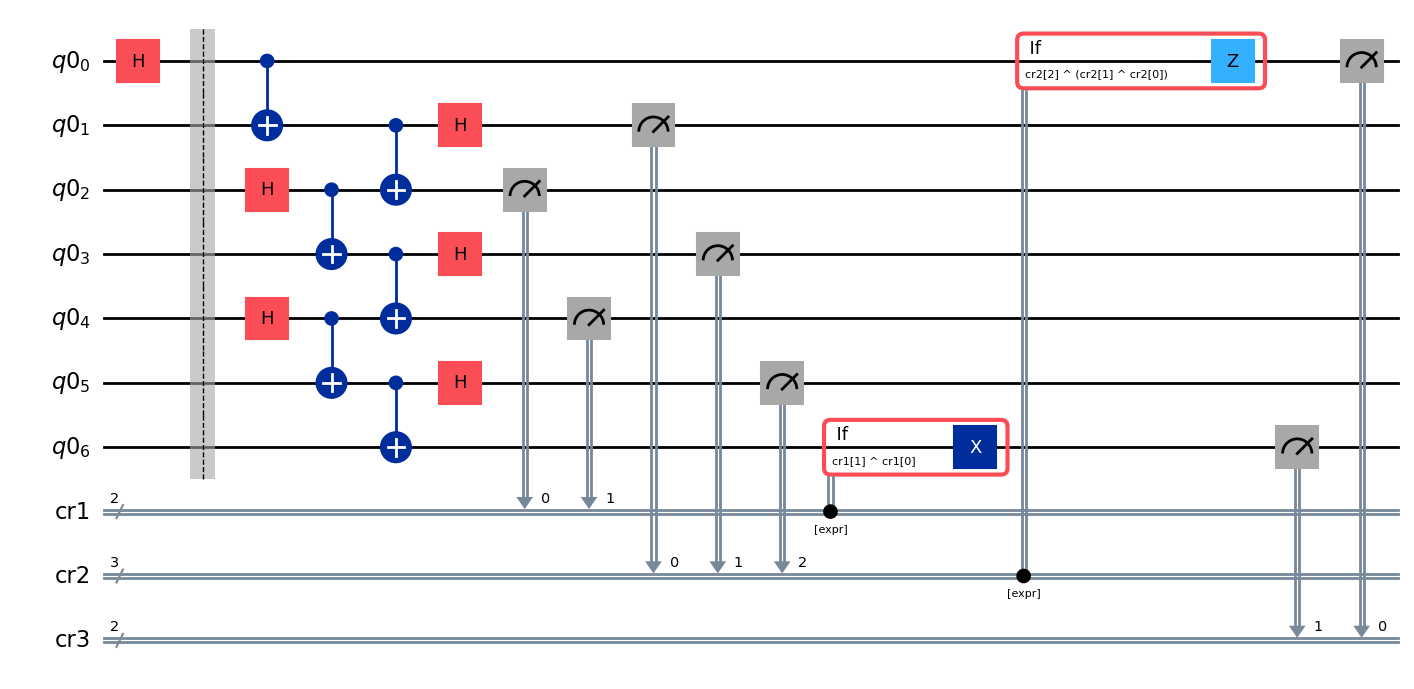

In [3]:
qc = get_CNOT_circuit_dynamic_1(num_qubit=7)
qc.draw(output='mpl')

In [4]:
#Creating list of circuits i.e. some copies of each of them

min_qubit=21
max_num_qubit=21
copies=20

#qc_list_dynamic_1=[]
#observables=[]

qc_list=[]
num_qubit_list=list(range(min_qubit,max_num_qubit+1))
for num_qubit in num_qubit_list:
    for i in range(copies):
        qc_list.append(get_CNOT_circuit_dynamic_1(num_qubit))
print(num_qubit_list)

[21]


In [5]:
#Ideal Simulation with AerSimulator
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Session, SamplerV2 as Sampler
 
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1, basis_gates=['snapshot', 'store', 'measure', 'barrier', 'h', 'cx'], translation_method='translator')
qc_transpiled_list=[]

qc_transpiled_list_ideal = pm.run(qc_list)

In [6]:
sampler = Sampler(backend=aer_sim)
result_ideal = sampler.run(qc_transpiled_list_ideal).result()

In [7]:
print(result_ideal)
len(result_ideal)

PrimitiveResult([PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))), PubResult(data=DataBin(cr1=BitArray(<shape=

20

In [8]:
# For getting list of ideal counts (argument required for Fidelity)
counts_list_ideal=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies): 
        data_dynamic_1 = result_ideal[(i*copies)+j].data 

        print(data_dynamic_1)
        
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        
        counts_list_ideal.append(counts_dynamic_1)

DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_

In [9]:
#Transpilation in real hardware

In [10]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance="ibm-q/open/main")
service.backends()

[<IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_osaka')>,
 <IBMBackend('ibm_sherbrooke')>]

In [11]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

backend_name = "ibm_brisbane"
service = QiskitRuntimeService()
backend = service.get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled_list = pm.run(qc_list)

In [12]:
#Executing the circuit
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)
job = sampler.run(qc_transpiled_list,shots=1024)
print(job.job_id())

ct1ejfhjyjyg008sp1jg


In [9]:
#Post-processing
import matplotlib.pyplot as plt
import statistics
from qiskit_ibm_runtime import QiskitRuntimeService

job_id = 'ct1ejfhjyjyg008sp1jg' #Brisbane

service = QiskitRuntimeService()
job = service.job(job_id)
result_real = job.result()

In [10]:
print(result_real)
len(result_real)

PrimitiveResult([PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}}), PubResult(data=DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<

20

In [11]:
#Finding the metrics of the job
result_metric_real=job.metrics()
print(result_metric_real)

{'timestamps': {'created': '2024-07-01T17:37:02.74105Z', 'finished': '2024-07-01T19:15:37.518Z', 'running': '2024-07-01T19:14:57.454Z'}, 'bss': {'seconds': 7}, 'usage': {'quantum_seconds': 7, 'seconds': 7}, 'executions': 0, 'num_circuits': 0, 'qiskit_version': 'qiskit_ibm_runtime-0.23.0,qiskit-1.1.0*,qiskit_aer-0.13.3*,qiskit_experiments-0.7.0', 'estimated_start_time': '2024-07-01T19:14:49.666Z', 'estimated_completion_time': '2024-07-01T19:14:56.504Z', 'caller': 'qiskit_ibm_runtime~sampler.py'}


In [12]:
print(type(result_metric_real['usage']['quantum_seconds']))

<class 'int'>


In [13]:
#Finding the runtime usage separately
result_usage_real=job.metrics()['usage']

print(result_usage_real)

print("Runtime Usage Information:")
for resource, usage in result_usage_real.items():
    print(f"{resource}: {usage}")

{'quantum_seconds': 7, 'seconds': 7}
Runtime Usage Information:
quantum_seconds: 7
seconds: 7


In [14]:
# For getting list of real counts of IBM brisbane (argument required for Fidelity)
counts_list_real=[]
for i in range(len(num_qubit_list)):  
    for j in range(copies):
        data_dynamic_1 = result_real[(i*copies)+j].data

        print(data_dynamic_1)
        
        counts_dynamic_1=data_dynamic_1.cr3.get_counts()
        
        counts_list_real.append(counts_dynamic_1)

DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_shots=1024, num_bits=2>))
DataBin(cr1=BitArray(<shape=(), num_shots=1024, num_bits=9>), cr2=BitArray(<shape=(), num_shots=1024, num_bits=10>), cr3=BitArray(<shape=(), num_

In [15]:
#Calculation of lists of Fidelity mean and std deviation of real hardware simulation in ibm_brisbane
import statistics
from qiskit.quantum_info.analysis import hellinger_fidelity
# We will create 4 lists of Fidelities, for storing mean, std deviation of Fidelity, of copies of a circuit for fixed no of logical qubits
 
Fidelity_mean_dynamic_1_brisbane=[]

#Fidelity_std_dynamic_1_brisbane=[]

Fidelity_copies_dynamic_1_brisbane=[]

for i in range(len(num_qubit_list)):
    
    for j in range(copies):
        
        Fidelity_dynamic_1=hellinger_fidelity(counts_list_ideal[(i*copies)+j], counts_list_real[(i*copies)+j])
        
        Fidelity_copies_dynamic_1_brisbane.append(Fidelity_dynamic_1)
    

    Fidelity_mean_dynamic_1_brisbane.append(statistics.mean(Fidelity_copies_dynamic_1_brisbane))
    
    #Fidelity_std_dynamic_1_brisbane.append(statistics.stdev(Fidelity_copies_dynamic_1_brisbane))
    
    Fidelity_copies_dynamic_1_brisbane.clear()

[0.5734609658871599]


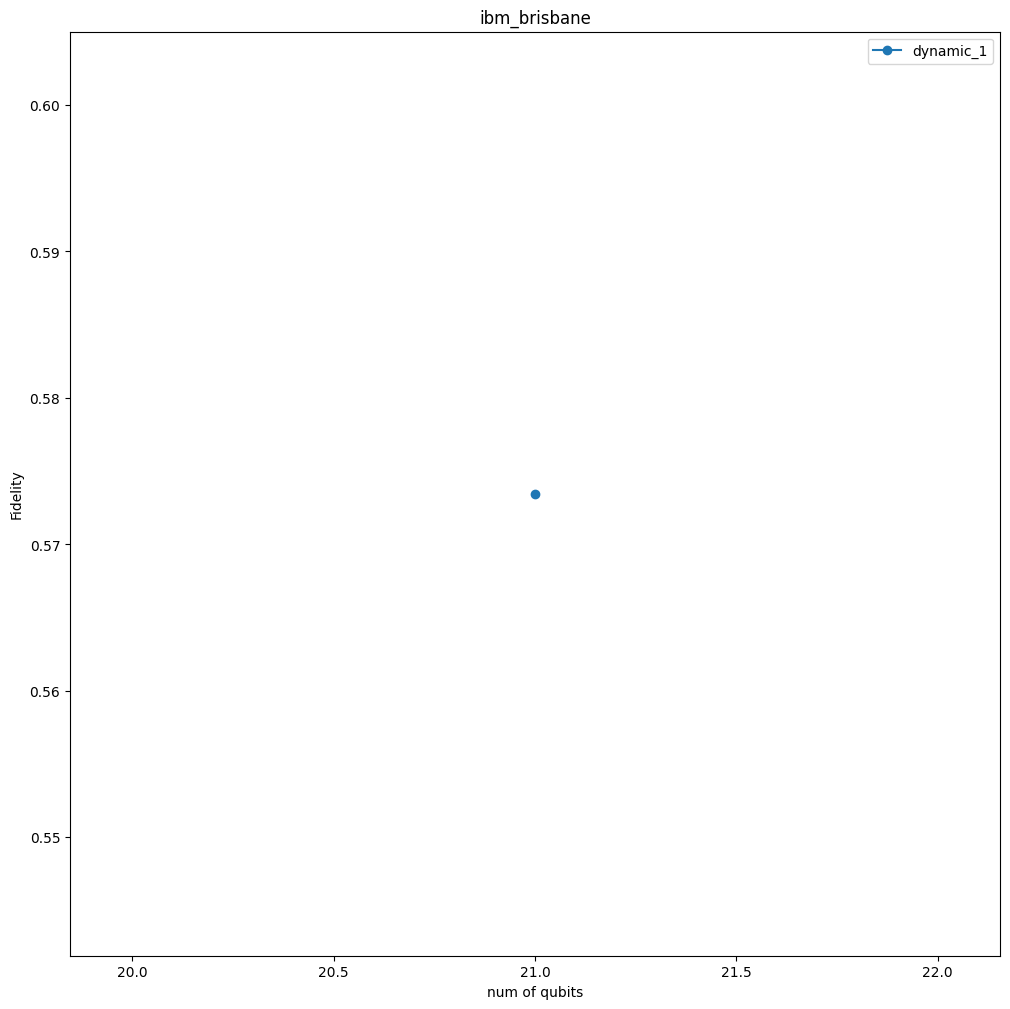

In [16]:
# Graph plotting
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
#figure(figsize=(16,12), dpi=180)
fig, ax1 = plt.subplots(1, 1, figsize=(12,12))

# Create  data.
ax1.set_xlabel('num of qubits')
ax1.set_ylabel('Fidelity')
ax1.set_title('ibm_brisbane')
x1 = num_qubit_list
y1_dynamic_1 = Fidelity_mean_dynamic_1_brisbane
print(y1_dynamic_1)
#y_error_dynamic_1 =Fidelity_std_dynamic_1_brisbane
ax1.plot(x1, y1_dynamic_1, 'o-',label='dynamic_1')
#ax1.errorbar(x1, y1_dynamic_1,
#			yerr = y_error_dynamic_1, label='dynamic_1',
#			fmt ='o')


plt.legend()
plt.show()